### Spatio-Temporal Variogram

First, load library and set encoding

In [14]:
library(ggplot2)
library(sqldf)
library(dplyr)
library(sp)
library(spacetime)
Sys.setlocale("LC_CTYPE", "thai")
options(encoding="UTF-8")

[1] "Thai_Thailand.874"

Set working directory (if needed)

In [2]:
setwd("C:\\Users\\garavig\\Documents\\Haze\\HazeAnalysis\\Data")

Load and update sensorlist id to the newest. เบอร์ของเก่าปีที่แล้วมันผิด มี 0 เยอะเกิน ต้องแก้ไขก่อน

In [3]:
sensorlist<-read.csv("https://raw.githubusercontent.com/Maplub/MonthlyAirQuality/master/sensorlist.csv",stringsAsFactors = FALSE)
sensorlist[sensorlist$sensorid=="CU-S00054",1]<-"CU-S0054"
sensorlist[sensorlist$sensorid=="CU-S00083",1]<-"CU-S0083"
sensorlist[sensorlist$sensorid=="CU-S00103",1]<-"CU-S0103"
sensorlist[sensorlist$sensorid=="CU-S00104",1]<-"CU-S0104"
sensorlist$sensorid <- as.factor(sensorlist$sensorid)

Load hourly data

In [5]:
hour<-read.csv("https://raw.githubusercontent.com/Maplub/AirQualityData/master/H_Mar_PM25_2561.csv")

In [20]:
head(hour)

sensorid,date,h,pm25,timepos
CU-S0002,2018-03-01,9,43.06250,2018-03-01 09:00:00
CU-S0002,2018-03-01,10,45.21875,2018-03-01 10:00:00
CU-S0002,2018-03-01,11,48.02083,2018-03-01 11:00:00
CU-S0002,2018-03-01,12,46.94792,2018-03-01 12:00:00
CU-S0002,2018-03-01,13,44.92708,2018-03-01 13:00:00
CU-S0002,2018-03-01,14,45.35417,2018-03-01 14:00:00


Update time to POSIXct

In [6]:
hour$timepos <- as.POSIXct(strptime(paste(hour$date,hour$h), "%Y-%m-%d %H"))

Select only one day, then order it by sensorid and timepos respectively.

In [ ]:
newhour<-hour[hour$timepos>="2018-03-08 00:00:00" & hour$timepos<="2018-03-08 23:00:00",]
newhour <- newhour[order(newhour$sensorid, newhour$timepos),]

Count number of rows per id to check the completeness of data. เช็คว่าข้อมูลทุก sensor มีครบ 24 ชั่วโมงหรือไม่

In [8]:
count<-sqldf("select sensorid,count() from newhour group by sensorid") 
colnames(count)<-c("sensorid","c")
sensorFull <-as.matrix(count[count$c == 24,]$sensorid)

Select only sensors that has 24 hour data

In [9]:
newhour<-subset(newhour,sensorid %in% sensorFull)

The model use 3 inputs:
1. Unique datetime list in order (วันที่แบบเรียงลำดับ)
2. Unique sensorid in order (id แบบ เรียงลำดับ)
3. Sensor data order by sensorid and time respectively (ข้อมูลเรียงลำดับตาม id กับ เวลา เพื่อให้เชื่อมกับ 1 กับ 2)

In [ ]:
datetime<-sqldf('select distinct(timepos) from newhour') #USE THIS
sensorid<-subset(sensorlist,sensorid %in% sensorFull)
sensorid <- sensorid[order(sensorid$sensorid),]

Create a SpatialPointsDataFrame

In [12]:
coordinates(sensorid)=~lon+lat
proj4string(sensorid)=CRS("+init=epsg:4326")

In [16]:
sensoridSP <- SpatialPoints(sensorid@coords,CRS("+init=epsg:4326")) 

Create spatio-temporal using STFDF function from spacetime library

In [18]:
stdata<-STFDF(sensoridSP,datetime$timepos,data.frame(PM2.5=as.vector(newhour$pm25)),delta(datetime$timepos))

Then plot it

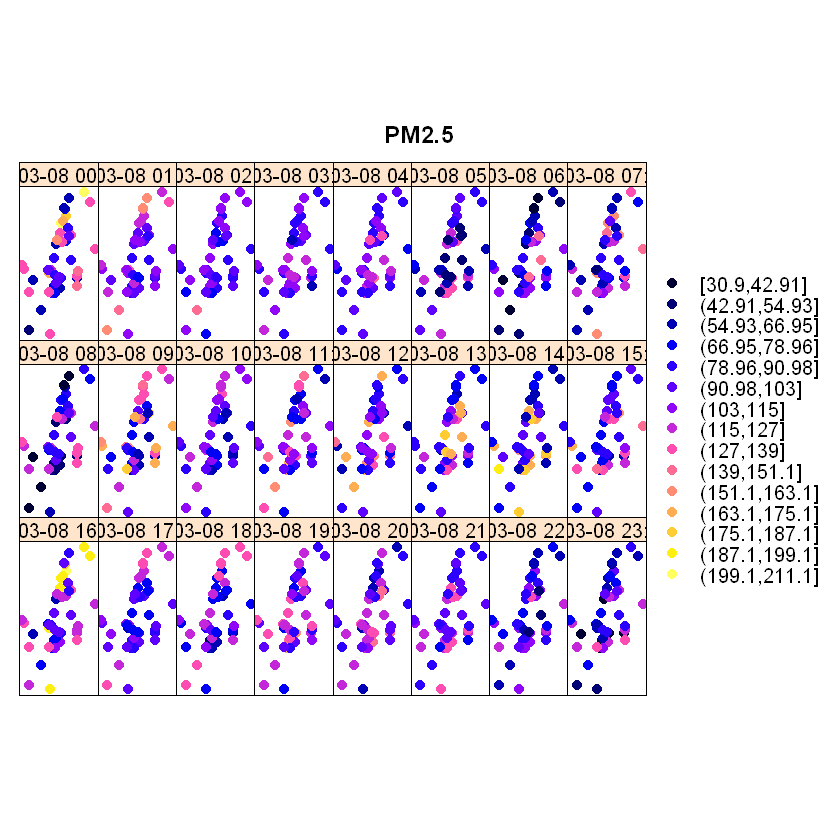

In [19]:
stplot(stdata)